In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from tomopt.muon import *
from tomopt.inference import *
from tomopt.volume import *
from tomopt.core import *
from tomopt.optimisation import *

import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
import numpy as np

import torch
from torch import Tensor, nn
import torch.nn.functional as F

# Basics

In [3]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

<ipython-input-4-edc514db5f58>:4: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(-10, 100*100)


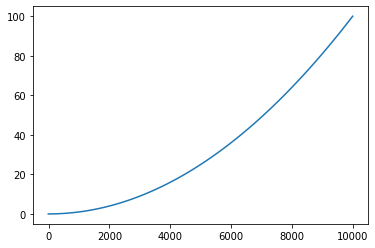

In [4]:
def area_cost(x:Tensor) -> Tensor:
    return F.relu(x/1000)**2

x = torch.linspace(-10, 100*100)
plt.plot(x, area_cost(x))

# Detector panels

In [26]:
gauss = torch.distributions.Normal(Tensor([0.5,0.5]), Tensor([0.5,1]))

In [34]:
torch.prod(torch.exp(gauss.log_prob(Tensor([[0.5,0.5], [1,1]])))/torch.exp(gauss.log_prob(Tensor([0.5,0.5]))),dim=-1)

tensor([1.0000, 0.5353])

In [341]:
class DetectorPanel(nn.Module):
    def __init__(
        self,
        res: float,
        eff: float,
        init_xyz:Tuple[float,float,float],
        init_xy_span: Tuple[float,float],
        area_cost_func: Callable[[Tensor], Tensor],
        device: torch.device = DEVICE
    ):
        if res <= 0:
            raise ValueError(f'Resolution must be positive')
        if eff <= 0:
            raise ValueError(f'Efficiency must be positive')
            
        super().__init__()
        self.area_cost_func, self.device = area_cost_func, device
        self.register_buffer('resolution', torch.tensor(float(res), requires_grad=True, device=self.device))
        self.register_buffer('efficiency', torch.tensor(float(eff), requires_grad=True, device=self.device))
        self.xyz = nn.Parameter(torch.tensor(init_xyz, device=self.device))
        self.xy_span = nn.Parameter(torch.tensor(init_xy_span, device=self.device))
        
    def __repr__(self) -> str:
        return f'''{self.__class__} located at {self.xyz.data}, and xy span {self.xy_span}'''
    
    def get_xy_mask(self, xy: Tensor) -> Tensor:
        xy_low = self.xy-(self.xy_span/2)
        xy_high = self.xy+(self.xy_span/2)
        return (xy[:,0] >= xy_low[0]) * (xy[:,0] < xy_high[0]) * (xy[:,1] >= xy_low[1]) * (xy[:,1] < xy_high[1])
    
    def get_resolution(self, xy:Tensor, mask:Optional[Tensor]=None) -> Tensor:
        if self.training:
            gauss = torch.distributions.Normal(self.xy, self.xy_span)  # maybe upscale span?
            res = self.resolution*torch.exp(gauss.log_prob(xy))/torch.exp(gauss.log_prob(self.xy))  # Maybe detach the normalisation?
        else:
            if mask is None:
                mask = self.get_xy_mask(xy)
            res = torch.zeros((len(xy),2), device=self.device)  # Zero detection outside detector
            res[mask] = self.resolution
        return res
    
    def get_efficiency(self, xy:Tensor, mask:Optional[Tensor]=None) -> Tensor:
        if self.training:
            gauss = torch.distributions.Normal(self.xy, self.xy_span)  # maybe upscale span?
            scale = torch.exp(gauss.log_prob(xy))/torch.exp(gauss.log_prob(self.xy))  # Maybe detach the normalisation?
            eff = self.efficiency*torch.prod(scale, dim=-1)  # Maybe weight product by xy distance?
        else:
            if mask is None:
                mask = self.get_xy_mask(xy)
            eff = torch.zeros(len(xy), device=self.device)  # Zero detection outside detector
            eff[mask] = self.efficiency
        return eff
        
    def get_hits(self, mu: MuonBatch) -> Dict[str, Tensor]:
        mask = mu.get_xy_mask(self.xy-(self.xy_span/2), self.xy+(self.xy_span/2))  # Muons in panel
        
        xy0 = self.xy-(self.xy_span/2)  # Low-left of voxel
        rel_xy = mu.xy - xy0
        res = self.get_resolution(mu.xy, mask)        
        rel_xy = rel_xy + (torch.randn((len(mu), 2), device=self.device) / res)
        
        if not self.training:  # Prevent reco hit from exiting panel
            span = self.xy_span.detach().cpu().numpy()
            rel_xy[mask] = torch.stack([torch.clamp(rel_xy[mask][:,0], 0, span[0]),
                                        torch.clamp(rel_xy[mask][:,1], 0, span[1])], dim=-1)  
        reco_xy = xy0 + rel_xy

        hits = {
            "reco_xy": reco_xy,
            "gen_xy": mu.xy,
            "z": self.z.expand_as(mu.x)[:, None],
        }
        return hits

    def get_cost(self) -> Tensor:
        return self.area_cost_func(self.xy_span.prod())
    
    @property
    def xy(self) -> Tensor:
        return self.xyz[:2]
    
    @property
    def z(self) -> Tensor:
        return self.xyz[2]

In [342]:
from tomopt.volume.layer import Layer

class DetectorLayer(Layer):
    def __init__(
        self,
        pos: str,
        lw: Tensor,
        z: float,
        size: float,
        panels: nn.ModuleList,
        device: torch.device = DEVICE,
    ):
        super().__init__(lw=lw, z=z, size=size, device=device)
        if isinstance(panels, list):
            panels = nn.ModuleList(panels)
        self.pos, self.panels = pos, panels
    
    def get_panel_zorder(self) -> List[int]:
        return np.argsort([p.z.detach().cpu().item() for p in self.panels])[::-1]
        
    def check_panels(self) -> None:
        with torch.no_grad(): 
            for p in self.panels:
                torch.clamp_(p.z, min=self.z.detach().cpu()[0]-self.size, max=self.z.detach().cpu()[0])

    def forward(self, mu: MuonBatch) -> None:
        self.check_panels()
        for i in self.get_panel_zorder():
            self.scatter_and_propagate(mu, mu.z-self.panels[i].z)  # Move to panel
            mu.append_hits(self.panels[i].get_hits(mu), self.pos)
        self.scatter_and_propagate(mu, mu.z-(self.z-self.size))  # Move to bottom of layer

    def get_cost(self) -> Tensor:
        for i, p in enumerate(self.panels):
            cost = p.get_cost() if i == 0 else cost + p.get_cost()
        return cost

In [343]:
panels = nn.ModuleList([DetectorPanel(res=1e4, eff=0.5, init_xyz=[0.5,0.5,0.95], init_xy_span=[0.5,0.5], area_cost_func=area_cost),
          DetectorPanel(res=1e4, eff=0.5, init_xyz=[0.5,0.5,1], init_xy_span=[0.5,0.5], area_cost_func=area_cost)])

In [344]:
muons = MuonBatch(generate_batch(100), init_z=1.0)

In [345]:
panels[0].get_hits(muons)

{'reco_xy': tensor([[0.8537, 0.3913],
         [0.5144, 0.1396],
         [0.6477, 0.0123],
         [0.6648, 0.5230],
         [0.5296, 0.3103],
         [0.0233, 0.0278],
         [0.4278, 0.3119],
         [0.9979, 0.8233],
         [0.2812, 0.4295],
         [0.3095, 0.5282],
         [0.5817, 0.6820],
         [0.2556, 0.2778],
         [0.1383, 0.8353],
         [0.1377, 0.9950],
         [0.9907, 0.5764],
         [0.5002, 0.2260],
         [0.5969, 0.6513],
         [0.8109, 0.4266],
         [0.7520, 0.7530],
         [0.0809, 0.7013],
         [0.2711, 0.5733],
         [0.8446, 0.5537],
         [0.8130, 0.5741],
         [0.6924, 0.1557],
         [0.1481, 0.5860],
         [0.0105, 0.4562],
         [0.4795, 0.3550],
         [0.5641, 0.1796],
         [0.7572, 0.0948],
         [0.3441, 0.5539],
         [0.6536, 0.4874],
         [0.0428, 0.7446],
         [0.6943, 0.1368],
         [0.6070, 0.9627],
         [0.4143, 0.7163],
         [0.3070, 0.2140],
         [0.1405,

In [346]:
dl = DetectorLayer(pos='above', lw=Tensor([1,1]), z=1, size=0.1, panels=panels)

In [347]:
dl.get_cost()

tensor(1.2500e-07, grad_fn=<AddBackward0>)

In [348]:
dl.get_panel_zorder()

array([1, 0])

In [349]:
dl.panels

ModuleList(
  (0): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.9500]), and xy span Parameter containing:
  tensor([0.5000, 0.5000], requires_grad=True)
  (1): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 1.0000]), and xy span Parameter containing:
  tensor([0.5000, 0.5000], requires_grad=True)
)

In [350]:
dl(muons)

In [351]:
muons.z

tensor([0.9000], grad_fn=<SubBackward0>)

In [352]:
muons.hits

defaultdict(<function tomopt.muon.muon_batch.MuonBatch.__init__.<locals>.<lambda>()>,
            {'above': defaultdict(list,
                         {'reco_xy': [tensor([[0.8539, 0.3912],
                                   [0.5144, 0.1395],
                                   [0.6473, 0.0123],
                                   [0.6649, 0.5231],
                                   [0.5294, 0.3103],
                                   [0.0230, 0.0281],
                                   [0.4280, 0.3116],
                                   [0.9977, 0.8231],
                                   [0.2811, 0.4296],
                                   [0.3094, 0.5281],
                                   [0.5818, 0.6822],
                                   [0.2553, 0.2778],
                                   [0.1382, 0.8355],
                                   [0.1375, 0.9951],
                                   [0.9905, 0.5761],
                                   [0.5002, 0.2258],
               

In [544]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    pos = 'above'
    n_panels = 4
    for z,d in zip(np.arange(lwh[2],0,-size), [1,0,0,0,0,0,0,1]):
        if d:
            layers.append(DetectorLayer(pos=pos, lw=lwh[:2], z=z, size=2*size,
                                        panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                              init_xyz=[0.5,0.5,z-(i*(2*size)/n_panels)], init_xy_span=[0.5,0.5],
                                                              area_cost_func=area_cost) for i in range(n_panels)]))
        else:
            pos = 'below'
            layers.append(PassiveLayer(rad_length_func=arb_rad_length, lw=lwh[:2], z=z, size=size))

    return nn.ModuleList(layers) 

In [569]:
class Volume(nn.Module):
    def __init__(self, layers: nn.ModuleList):
        super().__init__()
        if isinstance(layers, list):
            layers = nn.ModuleList(layers)
        self.layers = layers

    def __getitem__(self, idx:int) -> Layer:
        return self.layers[idx]

    def get_detectors(self) -> List[DetectorLayer]:
        return [l for l in self.layers if isinstance(l, DetectorLayer)]

    def get_passives(self) -> List[PassiveLayer]:
        return [l for l in self.layers if isinstance(l, PassiveLayer)]

    def get_rad_cube(self) -> Tensor:
        vols = list(reversed(self.get_passives()))  # reversed to match lookup_xyz_coords: layer zero = bottom layer
        if len(vols) == 0:
            raise ValueError("self.layers contains no passive layers")
        return torch.stack([v.rad_length for v in vols if v.rad_length is not None], dim=0)

    def lookup_passive_xyz_coords(self, xyz: Tensor) -> Tensor:
        r"""Assume same size for all layers for now and no intermedeate detector layers"""
        if len(xyz.shape) == 1:
            xyz = xyz[None, :]

        if n := (
            ((xyz[:, :2] > self.lw) + (xyz[:, :2] < 0)).sum(1) + (xyz[:, 2] < self.get_passive_z_range()[0]) + ((xyz[:, 2] > self.get_passive_z_range()[1]))
        ).sum():
            raise ValueError(f"{n} Coordinates outside passive volume")
        xyz[:, 2] = xyz[:, 2] - self.get_passive_z_range()[0]
        return torch.floor(xyz / self.size).long()

    def load_rad_length(self, rad_length_func: Callable[..., Tensor]) -> None:
        for p in self.get_passives():
            p.load_rad_length(rad_length_func)

    def forward(self, mu: MuonBatch) -> None:  # Expand to take volume as input, too
        for l in self.layers:
            l(mu)
            mu.snapshot_xyz()

    def get_cost(self) -> Tensor:
        cost = None
        for l in self.layers:
            if hasattr(l, "get_cost"):
                if cost is None:
                    cost = l.get_cost()
                else:
                    cost = cost + l.get_cost()
        if cost is None:
            cost = torch.zeros((1))
        return cost

    @property
    def lw(self) -> Tensor:
        return self.get_passives()[-1].lw

    @property
    def passive_size(self) -> float:
        return self.get_passives()[-1].size  # Same size for each passive layer

    @property
    def h(self) -> float:
        return self.layers[0].z

    def get_passive_z_range(self) -> Tuple[Tensor, Tensor]:
        ps = self.get_passives()
        return ps[-1].z - self.passive_size, ps[0].z

In [570]:
volume = Volume(get_layers())

In [571]:
volume[0].panels

ModuleList(
  (0): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 1.0000], dtype=torch.float64), and xy span Parameter containing:
  tensor([0.5000, 0.5000], requires_grad=True)
  (1): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.9500], dtype=torch.float64), and xy span Parameter containing:
  tensor([0.5000, 0.5000], requires_grad=True)
  (2): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.9000], dtype=torch.float64), and xy span Parameter containing:
  tensor([0.5000, 0.5000], requires_grad=True)
  (3): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.8500], dtype=torch.float64), and xy span Parameter containing:
  tensor([0.5000, 0.5000], requires_grad=True)
)

In [572]:
volume[0].panels[0].training

True

In [573]:
volume.eval()

Volume(
  (layers): ModuleList(
    (0): DetectorLayer(
      (panels): ModuleList(
        (0): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 1.0000], dtype=torch.float64), and xy span Parameter containing:
        tensor([0.5000, 0.5000], requires_grad=True)
        (1): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.9500], dtype=torch.float64), and xy span Parameter containing:
        tensor([0.5000, 0.5000], requires_grad=True)
        (2): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.9000], dtype=torch.float64), and xy span Parameter containing:
        tensor([0.5000, 0.5000], requires_grad=True)
        (3): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.8500], dtype=torch.float64), and xy span Parameter containing:
        tensor([0.5000, 0.5000], requires_grad=True)
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): P

In [574]:
volume[0].training

False

In [575]:
volume[0].panels.training

False

# Scatter inference

In [576]:
volume.eval()

Volume(
  (layers): ModuleList(
    (0): DetectorLayer(
      (panels): ModuleList(
        (0): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 1.0000], dtype=torch.float64), and xy span Parameter containing:
        tensor([0.5000, 0.5000], requires_grad=True)
        (1): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.9500], dtype=torch.float64), and xy span Parameter containing:
        tensor([0.5000, 0.5000], requires_grad=True)
        (2): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.9000], dtype=torch.float64), and xy span Parameter containing:
        tensor([0.5000, 0.5000], requires_grad=True)
        (3): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.8500], dtype=torch.float64), and xy span Parameter containing:
        tensor([0.5000, 0.5000], requires_grad=True)
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): P

In [591]:
muons = MuonBatch(generate_batch(100), init_z=1.0)

In [592]:
volume(muons)

In [593]:
hits = muons.get_hits(volume.lw)
above_hits = [torch.cat([hits["above"]["reco_xy"][:, i], hits["above"]["z"][:, i]], dim=-1) for i in range(hits["above"]["reco_xy"].shape[1])]
above_gen_hits = [torch.cat([hits["above"]["gen_xy"][:, i], hits["above"]["z"][:, i]], dim=-1) for i in range(hits["above"]["gen_xy"].shape[1])]
above_hits

[tensor([[   inf,    inf, 1.0000],
         [0.5132, 0.2790, 1.0000],
         [  -inf,    inf, 1.0000],
         [   inf,   -inf, 1.0000],
         [  -inf,   -inf, 1.0000],
         [0.7103, 0.3179, 1.0000],
         [   inf,    inf, 1.0000],
         [  -inf,    inf, 1.0000],
         [  -inf,    inf, 1.0000],
         [  -inf,   -inf, 1.0000],
         [  -inf,   -inf, 1.0000],
         [  -inf,   -inf, 1.0000],
         [0.3449, 0.6619, 1.0000],
         [   inf,    inf, 1.0000],
         [0.4820, 0.3869, 1.0000],
         [   inf,    inf, 1.0000],
         [0.6636, 0.6034, 1.0000],
         [   inf,   -inf, 1.0000],
         [   inf,    inf, 1.0000],
         [0.2884, 0.5669, 1.0000],
         [  -inf,    inf, 1.0000],
         [  -inf,   -inf, 1.0000],
         [  -inf,   -inf, 1.0000],
         [   inf,   -inf, 1.0000],
         [   inf,   -inf, 1.0000],
         [0.3105, 0.5319, 1.0000],
         [   inf,   -inf, 1.0000],
         [0.4703, 0.6597, 1.0000],
         [  -inf,   

In [594]:
[h[1] for h in above_hits]

[tensor([0.5132, 0.2790, 1.0000], dtype=torch.float64, grad_fn=<SelectBackward>),
 tensor([0.5053, 0.2780, 0.9500], dtype=torch.float64, grad_fn=<SelectBackward>),
 tensor([0.5006, 0.2736, 0.9000], dtype=torch.float64, grad_fn=<SelectBackward>),
 tensor([0.4934, 0.2718, 0.8500], dtype=torch.float64, grad_fn=<SelectBackward>)]

In [595]:
[h[0] for h in above_hits]

[tensor([inf, inf, 1.], dtype=torch.float64, grad_fn=<SelectBackward>),
 tensor([   inf,    inf, 0.9500], dtype=torch.float64, grad_fn=<SelectBackward>),
 tensor([  -inf,   -inf, 0.9000], dtype=torch.float64, grad_fn=<SelectBackward>),
 tensor([   inf,    inf, 0.8500], dtype=torch.float64, grad_fn=<SelectBackward>)]

In [596]:
def get_hit_uncs(dets: List[DetectorPanel], hits: List[Tensor]) -> List[Tensor]:
    res = []
    for l,h in zip(dets,hits):
        r = 1 / l.get_resolution(h[:,:2])
        res.append(torch.cat([r, torch.zeros((len(r),1), device=r.device)], dim=-1))
    return res

In [597]:
uncs = get_hit_uncs(volume.get_detectors()[0].panels, above_gen_hits)

In [598]:
uncs[0][:10]

tensor([[   inf,    inf, 0.0000],
        [   inf,    inf, 0.0000],
        [   inf,    inf, 0.0000],
        [   inf,    inf, 0.0000],
        [   inf,    inf, 0.0000],
        [0.0010, 0.0010, 0.0000],
        [   inf,    inf, 0.0000],
        [   inf,    inf, 0.0000],
        [   inf,    inf, 0.0000],
        [0.0010, 0.0010, 0.0000]], grad_fn=<SliceBackward>)

In [599]:
[u[1] for u in uncs]

[tensor([inf, inf, 0.], grad_fn=<SelectBackward>),
 tensor([inf, inf, 0.], grad_fn=<SelectBackward>),
 tensor([inf, inf, 0.], grad_fn=<SelectBackward>),
 tensor([inf, inf, 0.], grad_fn=<SelectBackward>)]

In [600]:
def get_muon_trajectory(hit_list: List[Tensor], unc_list: List[Tensor]) -> Tensor:
    r"""
    hits = [muons,(x,y,z)]
    uncs = [(unc,unc,0)]

    Assume no uncertainty for z
    
    In eval mode:
        Muons with <2 hits within panels have NaN trajectory.
        Muons with >=2 hits in panels have valid trajectories
    """

    hits, uncs = torch.stack(hit_list, dim=1), torch.stack(unc_list, dim=1)
    hits = torch.where(torch.isinf(hits), torch.tensor([0.5], dtype=torch.float64, device=uncs.device), hits)
    
    stars, angles = [],[]
    for i in range(2):  # seperate x and y resolutions
        inv_unc2 = uncs[:, :, i:i+1] ** -2
        sum_inv_unc2 = inv_unc2.sum(dim=1)
        mean_xz = torch.sum(hits[:,:,[i,2]] * inv_unc2, dim=1) / sum_inv_unc2
        mean_xz_z = torch.sum(hits[:,:,[i,2]] * hits[:, :, 2:3] * inv_unc2, dim=1) / sum_inv_unc2
        mean_x = mean_xz[:, :1]
        mean_z = mean_xz[:, 1:]
        mean_x_z = mean_xz_z[:, :1]
        mean_z2 = mean_xz_z[:, 1:]
        
        stars.append((mean_x - ((mean_z * mean_x_z) / mean_z2)) / (1 - (mean_z.square() / mean_z2)))
        angles.append((mean_x_z - (stars[-1] * mean_z)) / mean_z2)

    xy_star = torch.cat(stars, dim=-1)
    angle = torch.cat(angles, dim=-1)

    def _calc_xyz(z: Tensor) -> Tensor:
        return torch.cat([xy_star + (angle * z), z], dim=-1)

    return _calc_xyz(hits[:, 1, 2:3]) - _calc_xyz(hits[:, 0, 2:3])

In [601]:
get_muon_trajectory(above_hits, uncs)[:10]

tensor([[    nan,     nan, -0.0500],
        [    nan,     nan, -0.0500],
        [    nan,     nan, -0.0500],
        [    nan,     nan, -0.0500],
        [    nan,     nan, -0.0500],
        [-0.0085,  0.0081, -0.0500],
        [    nan,     nan, -0.0500],
        [    nan,     nan, -0.0500],
        [    nan,     nan, -0.0500],
        [ 0.0743, -0.0641, -0.0500]], dtype=torch.float64,
       grad_fn=<SliceBackward>)

In [636]:
from tomopt.utils import jacobian

class PanelScatterBatch(ScatterBatch):
    @staticmethod
    def get_muon_trajectory(hit_list: List[Tensor], unc_list: List[Tensor]) -> Tensor:
        r"""
        hits = [muons,(x,y,z)]
        uncs = [(unc,unc,0)]

        Assume no uncertainty for z

        In eval mode:
            Muons with <2 hits within panels have NaN trajectory.
            Muons with >=2 hits in panels have valid trajectories
        """

        hits, uncs = torch.stack(hit_list, dim=1), torch.stack(unc_list, dim=1)
        hits = torch.where(torch.isinf(hits), torch.tensor([0.5], dtype=torch.float64, device=uncs.device), hits)

        stars, angles = [],[]
        for i in range(2):  # seperate x and y resolutions
            inv_unc2 = uncs[:, :, i:i+1] ** -2
            sum_inv_unc2 = inv_unc2.sum(dim=1)
            mean_xz = torch.sum(hits[:,:,[i,2]] * inv_unc2, dim=1) / sum_inv_unc2
            mean_xz_z = torch.sum(hits[:,:,[i,2]] * hits[:, :, 2:3] * inv_unc2, dim=1) / sum_inv_unc2
            mean_x = mean_xz[:, :1]
            mean_z = mean_xz[:, 1:]
            mean_x_z = mean_xz_z[:, :1]
            mean_z2 = mean_xz_z[:, 1:]

            stars.append((mean_x - ((mean_z * mean_x_z) / mean_z2)) / (1 - (mean_z.square() / mean_z2)))
            angles.append((mean_x_z - (stars[-1] * mean_z)) / mean_z2)

        xy_star = torch.cat(stars, dim=-1)
        angle = torch.cat(angles, dim=-1)

        def _calc_xyz(z: Tensor) -> Tensor:
            return torch.cat([xy_star + (angle * z), z], dim=-1)

        return _calc_xyz(hits[:, 1, 2:3]) - _calc_xyz(hits[:, 0, 2:3])
    
    @staticmethod
    def get_hit_uncs(dets: List[DetectorPanel], hits: List[Tensor]) -> List[Tensor]:
        res = []
        for l,h in zip(dets,hits):
            r = 1 / l.get_resolution(h[:,:2])
            res.append(torch.cat([r, torch.zeros((len(r),1), device=r.device)], dim=-1))
        return res
    
    def compute_scatters(self) -> None:
        r"""
        Currently only handles detectors above and below passive volume

        Scatter locations adapted from:
        @MISC {3334866,
            TITLE = {Closest points between two lines},
            AUTHOR = {Brian (https://math.stackexchange.com/users/72614/brian)},
            HOWPUBLISHED = {Mathematics Stack Exchange},
            NOTE = {URL:https://math.stackexchange.com/q/3334866 (version: 2019-08-26)},
            EPRINT = {https://math.stackexchange.com/q/3334866},
            URL = {https://math.stackexchange.com/q/3334866}
        }
        """

        # reco x, reco y, gen z, must be a list to allow computation of uncertainty
        self.above_hits = [torch.cat([self.hits["above"]["reco_xy"][:, i], self.hits["above"]["z"][:, i]], dim=-1) for i in range(self.hits["above"]["reco_xy"].shape[1])]
        self.below_hits = [torch.cat([self.hits["below"]["reco_xy"][:, i], self.hits["below"]["z"][:, i]], dim=-1) for i in range(self.hits["below"]["reco_xy"].shape[1])]
        self.above_gen_hits = [torch.cat([self.hits["above"]["gen_xy"][:, i], self.hits["above"]["z"][:, i]], dim=-1) for i in range(self.hits["above"]["gen_xy"].shape[1])]
        self.below_gen_hits = [torch.cat([self.hits["below"]["gen_xy"][:, i], self.hits["below"]["z"][:, i]], dim=-1) for i in range(self.hits["below"]["gen_xy"].shape[1])]
        self.n_hits_above = len(self.above_hits)
        
        self.above_hit_uncs = self.get_hit_uncs(self.volume.get_detectors()[0].panels, self.above_gen_hits)
        self.below_hit_uncs = self.get_hit_uncs(self.volume.get_detectors()[1].panels, self.below_gen_hits)
    
        v1 = self.get_muon_trajectory(self.above_hits, self.above_hit_uncs)
        v2 = self.get_muon_trajectory(self.below_hits, self.below_hit_uncs)

        # scatter locations
        v3 = torch.cross(v1, v2, dim=1)  # connecting vector perpendicular to both lines
        rhs = self.below_hits[0] - self.above_hits[0]
        lhs = torch.stack([v1, -v2, v3], dim=1).transpose(2, 1)
        coefs = torch.linalg.solve(lhs, rhs)  # solve p1+t1*v1 + t3*v3 = p2+t2*v2 => p2-p1 = t1*v1 - t2*v2 + t3*v3

        q1 = self.above_hits[0] + (coefs[:, 0:1] * v1)  # closest point on v1
        self._loc = q1 + (coefs[:, 2:3] * v3 / 2)  # Move halfway along v3 from q1
        self._loc_unc: Optional[Tensor] = None

        # Theta deviations
        self._theta_in = torch.arctan(v1[:, :2] / v1[:, 2:3])
        self._theta_out = torch.arctan(v2[:, :2] / v2[:, 2:3])
        self._dtheta = torch.abs(self._theta_in - self._theta_out)
        self._theta_in_unc: Optional[Tensor] = None
        self._theta_out_unc: Optional[Tensor] = None
        self._dtheta_unc: Optional[Tensor] = None

        # xy deviations
        self._dxy = coefs[:, 2:3] * v3[:, :2]
        self._dxy_unc: Optional[Tensor] = None
            
    def _compute_unc(self, var: Tensor, hits: List[Tensor], hit_uncs: List[Tensor]) -> Tensor:
        unc2_sum = None
        for i, (xi, unci) in enumerate(zip(hits, hit_uncs)):
            for j, (xj, uncj) in enumerate(zip(hits, hit_uncs)):
                if j < i:
                    continue
                dv_dx_2 = torch.nan_to_num(jacobian(var, xi)).sum(2) * torch.nan_to_num(jacobian(var, xj)).sum(2) if i != j else torch.nan_to_num(jacobian(var, xi)).sum(2) ** 2  # Muons, var_xyz, hit_xyz
                unc_2 = (dv_dx_2 * unci[:, None] * uncj[:, None]).sum(2)  # Muons, (x,y,z)
                if unc2_sum is None:
                    unc2_sum = unc_2
                else:
                    unc2_sum = unc2_sum + unc_2
        return torch.sqrt(unc2_sum)

In [637]:
sb = PanelScatterBatch(muons, volume)

In [638]:
sb.location[:10], sb.location_unc[:10]

(tensor([[   nan,    nan,    nan],
         [   nan,    nan,    nan],
         [   nan,    nan,    nan],
         [   nan,    nan,    nan],
         [   nan,    nan,    nan],
         [0.6238, 0.3988, 0.5009],
         [   nan,    nan,    nan],
         [   nan,    nan,    nan],
         [   nan,    nan,    nan],
         [   nan,    nan,    nan]], dtype=torch.float64,
        grad_fn=<SliceBackward>),
 tensor([[   nan,    nan,    nan],
         [   nan,    nan,    nan],
         [   nan,    nan,    nan],
         [   nan,    nan,    nan],
         [   nan,    nan,    nan],
         [0.0491, 0.0484, 0.2836],
         [   nan,    nan,    nan],
         [   nan,    nan,    nan],
         [   nan,    nan,    nan],
         [0.0003, 0.0004, 0.0005]], dtype=torch.float64,
        grad_fn=<SliceBackward>))

In [639]:
m = sb.get_scatter_mask()

In [640]:
sb.location[m][:10], sb.location_unc[m][:10]

(tensor([[0.6238, 0.3988, 0.5009],
         [0.3305, 0.6694, 0.6900],
         [0.4685, 0.3809, 0.5706],
         [0.6321, 0.5708, 0.6970],
         [0.2928, 0.5149, 0.6623],
         [0.5208, 0.6937, 0.3816],
         [0.4517, 0.5210, 0.8136],
         [0.4293, 0.4663, 0.8717],
         [0.6872, 0.6016, 0.6620],
         [0.4939, 0.3529, 0.6349]], dtype=torch.float64,
        grad_fn=<SliceBackward>),
 tensor([[0.0491, 0.0484, 0.2836],
         [0.0159, 0.0076, 0.3142],
         [0.0042, 0.0038, 0.1610],
         [0.0170, 0.0158, 0.1505],
         [0.0025, 0.0326, 0.2090],
         [0.0094, 0.0101, 0.1242],
         [0.0099, 0.0370, 0.3888],
         [0.0226, 0.0135, 0.1636],
         [0.0072, 0.0058, 0.1727],
         [0.0072, 0.0034, 0.1324]], dtype=torch.float64,
        grad_fn=<SliceBackward>))

# VolumeWrapper

In [ ]:
from functools import partial

In [ ]:
volume = Volume(get_layers())

In [ ]:
wrapper = VolumeWrapper(volume=volume, res_opt=partial(torch.optim.SGD, lr=2e10), eff_opt=partial(torch.optim.SGD, lr=2e5),
                        loss_func=DetectorLoss(0))

In [ ]:
from tomopt.optimisation import MetricLogger

In [ ]:
ml = MetricLogger(show_plots=True)

In [ ]:
trn_passives = PassiveYielder([arb_rad_length])

In [ ]:
from tomopt.optimisation.callbacks.callback import Callback

In [ ]:
class ParamCap(Callback):
    def on_volume_batch_begin(self) -> None:
        with torch.no_grad():
            for d in self.wrapper.volume.get_detectors():
                torch.clamp_(d.resolution, min=1, max=1e7)
                torch.clamp_(d.efficiency, min=1e-7, max=1)

In [ ]:
%%time
_ = wrapper.fit(25, n_mu_per_volume=1000, mu_bs=100, passive_bs=1, trn_passives=trn_passives, val_passives=trn_passives, cbs=[NoMoreNaNs(),ParamCap(),ml])

In [ ]:
for d in volume.get_detectors():
    print(1, d.resolution, d.efficiency)